In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.adapters import focuss
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

# Get Forward Model

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.4s remaining:    3.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


# Get sample data

In [45]:
settings = dict(number_of_sources=1, extents=1, duration_of_trial=0.1, target_snr=10)
# settings = dict(number_of_sources=1, extents=25, duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
M = evoked.data
M -= M.mean(axis=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]

Using control points [0.00000000e+00 0.00000000e+00 3.17927164e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# Minimum Norm Estimate

In [4]:
alpha = 0.001
# if n_chans>n_dipoles:
# D_MNE = np.linalg.inv(leadfield.T @ leadfield + alpha * np.identity(n_dipoles)) @ leadfield.T @ M
# else:
D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M


stc_hat = stc.copy()
stc_hat.data = D_MNE
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE', 'title',
               font_size=14)

Using control points [4.10336231e-09 5.37624062e-09 2.05873333e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [3.08605966e-09 3.98129040e-09 1.09998127e-08]
Using control points [6.18467587e-09 8.21353217e-09 5.39839727e-08]


# Weighted Minimum Norm Estimate

In [5]:
alpha = 0.001
omega = np.diag(np.linalg.norm(leadfield, axis=0))
I_3 = np.identity(3)
W = omega # np.kron(omega, I_3)

D_WMNE = np.linalg.inv(W.T @ W) @ leadfield.T  @ np.linalg.inv(leadfield @ np.linalg.inv(W.T @ W) @ leadfield.T + alpha * np.identity(n_chans)) @ M

stc_hat = stc.copy()
stc_hat.data = D_WMNE
r = np.median([pearsonr(abs(s_pred), abs(s_true))[0] for s_pred, s_true in zip(stc_hat.data.T, stc.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'wMNE (r={r:.2f})', 'title',
               font_size=14)

Using control points [4.08305412e-09 5.37580985e-09 1.69555175e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [2.89564412e-09 3.76475241e-09 9.22730534e-09]


# MNE with FOCUSS (Focal underdetermined system solution)

In [ ]:
alpha = 0.001

D_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans)) @ M
D_FOCUSS = focuss(D_MNE, M, leadfield, alpha)

stc_hat = stc.copy()
stc_hat.data = D_FOCUSS
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'MNE FOCUSS', 'title',
            font_size=14)

# Contextual Minimum Norm

In [ ]:
from invert import inverse_loreta, contextualize, contextualize_bd
import tensorflow as tf
from scipy.stats import pearsonr


stc_instant = inverse_loreta(M, leadfield, fwd)
D_cmne = contextualize_bd(stc_instant, leadfield, num_epochs=20)

stc = sim.source_data[0]


stc_hat = stc.copy()
stc_hat.data = D_cmne
r = np.median([pearsonr(abs(s_pred), abs(s_true))[0] for s_pred, s_true in zip(stc_hat.data.T, stc.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'CMNE (r={r:.2f})', 'title',
               font_size=14)

# dSPM

In [ ]:
alpha = 0.001

noise_cov = np.identity(n_chans) + np.random.rand(n_chans, n_chans)*0.1
source_cov = np.identity(n_dipoles)

M_norm = (1/np.sqrt(noise_cov)) @ M
G_norm = (1/np.sqrt(noise_cov)) @ leadfield

K = source_cov @ G_norm.T @ np.linalg.inv(G_norm @ source_cov @ G_norm.T + alpha**2 * np.identity(n_chans))
W_dSPM = np.diag(np.sqrt(1/np.diagonal(K @ noise_cov @ K.T)))
K_dSPM = W_dSPM @ K
D_dSPM = K_dSPM @ M_norm


stc_hat = stc.copy()
stc_hat.data = D_dSPM
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'dSPM', 'title',
               font_size=14)

# LORETA

In [ ]:
alpha = 2
adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M
# D_LOR = np.linalg.inv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ (leadfield @ np.linalg.pinv(B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T + alpha * np.identity(n_chans) ) @ M

stc_hat = stc.copy()
D_LOR /= np.abs(D_LOR).max()
stc_hat.data = D_LOR
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'LORETA (r={r:.2f})', 'title',
            font_size=14)

# sLORETA

In [ ]:
alpha = 0.001
K_MNE = leadfield.T @ np.linalg.inv(leadfield @ leadfield.T + alpha * np.identity(n_chans))
W_diag = 1 / np.diag(K_MNE @ leadfield)

W_slor = np.diag(W_diag)

W_slor = np.sqrt(W_slor)

K_slor = W_slor @ K_MNE
D_SLOR = K_slor @ M
D_SLOR[np.isnan(D_SLOR)] = 0

stc_hat = stc.copy()
stc_hat.data = D_SLOR
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'sLORETA (r={r:.2f})', 'title',
            font_size=14)

In [46]:
# sLORETA 2
# Ne = channels
# Nv = dipoles
alpha = 0.001
n_chans, n_time = M.shape
I = np.identity(n_chans)
one = np.ones((n_chans, 1))
H = I - (one @ one.T) / (one.T @ one)
T = leadfield.T @ H @ np.linalg.pinv(H @ leadfield @ leadfield.T @ H + alpha * H)
D_SLOR = T @ M

stc_hat = stc.copy()
stc_hat.data = D_SLOR
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'sLORETA (r={r:.2f})', 'title',
            font_size=14)

Using control points [6.26519107e-09 7.99507419e-09 3.92039415e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# eLORETA

In [ ]:
from invert import calc_eloreta_D
stop_crit = 0.005
alpha = 0.001

D, C = calc_eloreta_D(leadfield, alpha, stop_crit=stop_crit)
K_elor = np.linalg.inv(D) @ leadfield.T @ np.linalg.inv( leadfield @ np.linalg.inv(D) @ leadfield.T + alpha * np.identity(n_chans) )
D_ELOR = K_elor @ M

stc_hat = stc.copy()
stc_hat.data = D_ELOR
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'eLORETA (r={r:.2f})', 'title',
            font_size=14)

In [50]:
# eLORETA 2
# Ne = channels
# Nv = dipoles
from copy import deepcopy
alpha = 0
n_chans, n_time = M.shape
I = np.identity(n_chans)
one = np.ones((n_chans, 1))
H = I - (one @ one.T) / (one.T @ one)
W = np.diag(np.linalg.norm(leadfield, axis=0))
W_inv = np.linalg.inv(W)
max_iter = 100
MM = np.linalg.pinv(leadfield @ W_inv @ leadfield.T + alpha * H)
W_last = np.zeros((n_dipoles, n_dipoles))
changes = [1e99]
norms = [1e99,]
thresh = 0.01
for i in range(max_iter):
    W_i = leadfield.T @ MM @ leadfield
    W_i = np.sqrt(np.diag(np.diagonal(W_i)))
    w_change = np.linalg.norm(W_i - W_last)
    print(w_change)
    if w_change < thresh:
        W = deepcopy(W_i)
        break    
    W_last = deepcopy(W_i)
    
T = np.linalg.inv(W) @ leadfield.T @ np.linalg.pinv(leadfield @ np.linalg.inv(W) @ leadfield.T + alpha * H)

D_ELOR = T @ M

stc_hat = stc.copy()
stc_hat.data = D_ELOR
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'eLORETA 2 (r={r:.2f})', 'title',
            font_size=14)

297.89881031617733
0.0
Using control points [7.70123834e-09 9.49657403e-09 3.52891090e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [7.40533132e-09 8.75794692e-09 1.73669644e-08]


# LAURA

In [ ]:
alpha = 200
drop_off = 2
d = cdist(pos, pos)
# Get the adjacency matrix of the source spaces
adj = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
for i in range(d.shape[0]):
    # find dipoles that are no neighbor to dipole i
    non_neighbors = np.where(~adj.astype(bool)[i, :])[0]
    # append dipole itself
    non_neighbors = np.append(non_neighbors, i)
    # set non-neighbors to zero
    d[i, non_neighbors] = 0
A = -d**-drop_off
A[np.isinf(A)] = 0
W = np.identity(A.shape[0])
M_j = W @ A

# Source Space metric
W_j = np.linalg.inv(M_j.T @ M_j)
W_j_inv = np.linalg.inv(W_j)

W_d = np.linalg.inv(np.identity(n_chans))
noise_term = (alpha**2) * np.linalg.inv(W_d)
G = W_j_inv @ leadfield.T @ np.linalg.inv(leadfield @ W_j_inv @ leadfield.T + noise_term)
D_LAURA = G @ M

stc_hat.data = D_LAURA
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'LAURA (r={r:.2f})', 'title',
            font_size=14)

# VARETA

In [ ]:
# 1) J & JVareta given; find A
# 2) A given, find J
# 3) repeat until convergence

In [ ]:
 
# alpha = 0.001
# adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()
# B = np.diag(np.linalg.norm(leadfield, axis=0))
# L = laplacian(adjacency)  # non-singular univariate discrete laplacian -> is that correct?
# D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ L.T @ L @ B) @ leadfield.T @ M
# D_Last = deepcopy(D_LOR)[:, 0][:, np.newaxis]
# W = np.diag(np.linalg.norm(leadfield, axis=0))  # WMNE weight matrix (depth weighting)
# tau = 1  # controls smoothness
# alpha_2 = 1  # controls importance of grid point
# # for t in range(M.shape[1]):
# t = 0
# A = np.identity(n_dipoles)  # in paper: large lambda
    
# # for _ in range(10):
# term_1 = np.linalg.norm( M[:, t] - leadfield @ D_Last )
# term_2 = np.linalg.norm( A@L * W * D_Last )
# term_3 = tau**2 * np.linalg.norm( L * np.diag(np.log(np.diagonal(A))) - alpha_2 )


# # D_VAR = term_1 + term_2 + term_3

# from scipy.optimize import minimize
# def find_lambda(A, m, leadfield, D_Last, L, W, tau, alpha_2):
#     A = A.reshape(leadfield.shape[1], leadfield.shape[1])
#     term_1 = np.linalg.norm( M[:, t] - leadfield @ D_Last )
#     term_2 = np.linalg.norm( A@L * W * D_Last )
#     term_3 = tau**2 * np.linalg.norm( L * np.diag(np.log(np.diagonal(A))) - alpha_2 )
#     return term_1 + term_2 + term_3
# # find_lambda(A, M[:, t], leadfield, D_Last, L, W, tau, alpha_2)
# minimize(find_lambda, A.flatten(), args=(M[:, t], leadfield, D_Last, L, W, tau, alpha_2), method='L-BFGS-B')

# S-MAP

In [5]:
alpha = 0.001
adjacency = mne.spatial_src_adjacency(fwd['src']).toarray()
B = np.diag(np.linalg.norm(leadfield, axis=0))
laplace_operator = laplacian(adjacency)
D_LOR = np.linalg.inv(leadfield.T @ leadfield + alpha * B @ laplace_operator.T @ laplace_operator @ B) @ leadfield.T @ M

gradient = np.gradient(B)[0] #np.gradient(B)[0]
D_SMAP = np.linalg.inv(leadfield.T @ leadfield + alpha * gradient.T @ gradient) @ leadfield.T @ M
# D_SMAP = np.linalg.inv(gradient.T @ gradient) @ leadfield.T @ np.linalg.inv(leadfield @ np.linalg.inv( gradient.T @ gradient ) @ leadfield.T + alpha * np.identity(n_chans)) @ M

stc_hat = stc.copy()
stc_hat.data = D_SMAP
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'S-MAP (r={r:.2f})', 'title',
            font_size=14)

-- number of adjacent vertices : 1284
Using control points [7.35968128e-09 9.53787601e-09 2.72470932e-08]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [3.34827580e-09 4.01349516e-09 6.88505491e-09]
Using control points [3.10302337e-09 3.58375427e-09 8.05604369e-09]
Using control points [3.06603482e-09 3.49012487e-09 6.18109851e-09]
Using control points [1.85061260e-09 2.57456726e-09 1.28449832e-08]
Using control points [1.02169732e-08 1.26327276e-08 2.06648478e-08]
Using control points [7.40397775e-09 8.89350830e-09 1.46702587e-08]
Using control points [1.65547772e-09 2.11952751e-09 8.40794931e-09]
Using control points [2.15190964e-09 2.59001994e-09 3.99474721e-09]
Using control points [3.05550428e-10 1.35564108e-09 1.81373825e-08]
Using control points [1.76870253e-10 1.06454415e-09 1.18943805e-08]
Using control points [2.04128420e-10 9.13980860e-10 1.31557843e-08]
Using control points [4.16117485e-12 2.50452198e-11 1.79075588e-08]
Using control points [4.61471351e-10 2.20934384e-09 3.71231778e-08]
Using control points [4.83465753e-10 1.99159172e-09 2.99959703e-08]
Using control points [5.82142147e-11 3.50378884e

# ESINET

In [ ]:
from esinet import Net
import tensorflow as tf
sim_train = Simulation(fwd, info, settings=dict(duration_of_trial=0, target_snr=999)).simulate(10000)
net = Net(fwd, n_dense_units=512, n_lstm_layers=0, activation_function='tanh').fit(sim_train)
# del sim_train

D_ESINET = net.predict(sim.eeg_data[0])[0].data

stc_hat = stc.copy()
stc_hat.data = D_ESINET
r = np.mean([pearsonr(a, b)[0] for a, b in zip(stc_hat.data.T, stc.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'ESINET (r={r:.2f})', 'title',
            font_size=14)


D_cESINET = contextualize_bd(D_ESINET, fwd)
stc_hat.data = D_cESINET
brain = stc_hat.plot(**pp)
r = np.mean([pearsonr(a, b)[0] for a, b in zip(stc_hat.data.T, stc.data.T)])
brain.add_text(0.1, 0.9, f'cESINET (r={r:.2f})', 'title',
            font_size=14)

# Backus-Gilbert

In [ ]:
# Calculate distance matrix
dist = cdist(pos, pos)

print("Get W_BG")
W_BG = []
for i in range(n_dipoles):
    W_gamma_BG = np.diag(dist[i, :])
    W_BG.append(W_gamma_BG)

print("Get C")
C = []
for i in range(n_dipoles):
    C_gamma = leadfield @ W_BG[i] @ leadfield.T
    C.append(C_gamma)

print("Get F")
F = leadfield @ leadfield.T

print("Get E")
E = []
for i in range(n_dipoles):
    E_gamma = C[i] + F
    E.append(E_gamma)

print("Get L")
L = leadfield @ np.ones((n_dipoles, 1))

print("Get T")
T = []
for i in range(n_dipoles):
    E_gamma_pinv = np.linalg.pinv(E[i])
    T_gamma = (E_gamma_pinv @ L) / (L.T @ E_gamma_pinv @ L)
    T.append(T_gamma)

T_final = np.stack(T, axis=0)[:, :, 0]
D_BG = T_final @ M

stc_hat = stc.copy()
stc_hat.data = D_BG
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Backus-Gilbert', 'title',
            font_size=14)

# Multiple Sparse Priors

In [ ]:
D_MSP = inverse_msp(evoked, fwd)

stc_hat = stc.copy()
stc_hat.data = D_MSP
r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, f'MSP (r={r:.2f})', 'title',
            font_size=14)

# D_bLORETA = inverse_msp(evoked, fwd, inversion_type="LORETA")

# stc_hat = stc.copy()
# stc_hat.data = D_bLORETA
# r = np.median([pearsonr(a, b)[0] for a, b in zip(stc.data.T, stc_hat.data.T)])
# brain = stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, f'Bayesian LORETA (r={r:.2f})', 'title',
#             font_size=14)


# LUCAS

In [ ]:
stc_hat.data = np.mean([D_MNE , D_WMNE, D_LOR, D_SLOR, D_ELOR, D_LAURA, D_SMAP, D_ESINET, D_BG, D_MSP], axis=0)
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'LUCAS', 'title',
            font_size=14)

stc_hat.data = contextualize(stc_hat.data, fwd)
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'cLUCAS', 'title',
            font_size=14)

# Beamformer

In [72]:
alpha = 0

leadfield -= leadfield.mean(axis=0)
M -= M.mean(axis=0)
C = M @ M.T
C_inv = np.linalg.inv(C)

W = 1 / (leadfield.T @ C_inv @ leadfield + alpha * np.identity(n_dipoles))  @ leadfield.T @ C_inv


variance = [(W[i] @ C @ W[i]) for i in range(n_dipoles)]


In [73]:
W[0,] @ C @ W[0]

-1.7542783138884414e-24

In [74]:
stc_hat = stc.copy()
stc_hat.data *= 0
stc_hat.data = W@M

brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Beamformer', 'title',
               font_size=14)

Using control points [1.06659282e-19 1.76909612e-19 4.87191042e-18]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [2.98035494e-20 4.93597704e-20 8.91943502e-19]


Using control points [1.32910659e-18 2.16205788e-18 6.74724713e-15]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


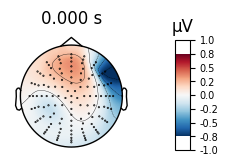

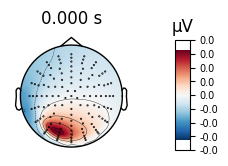

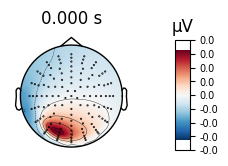

Using control points [0.00000000e+00 0.00000000e+00 1.67218114e-09]
Using control points [5.81553726e-19 9.48912115e-19 8.14996306e-16]


In [34]:
v_sq = 1
mu = 0
alpha = 0
leadfield -= leadfield.mean(axis=0)
M -= M.mean(axis=0)

C = M @ M.T
C_inv = np.linalg.inv(C)

reg_term = np.linalg.inv(C + mu*v_sq*np.identity(n_chans))

W = 1 / (leadfield.T @ C_inv @ leadfield + alpha * np.identity(n_dipoles))  @ leadfield.T @ C_inv
# P = W @ C @ W
D_LCMV = W @ M

stc_hat = stc.copy()
stc_hat.data = D_LCMV

brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Beamformer', 'title',
               font_size=14)


evoked_hat = mne.EvokedArray(leadfield @ stc.data, evoked.info)
evoked_hat.plot_topomap(times=[0])


evoked_hat = mne.EvokedArray(leadfield @ stc_hat.data, evoked.info)
evoked_hat.plot_topomap(times=[0])


In [23]:

leadfield -= leadfield.mean(axis=0)
M -= M.mean(axis=0)
C = M @ M.T
C_inv = np.linalg.inv(C)
N = np.identity(n_chans)

W = []
P = []
roh = []
mu = 0#100
v_sq = 1# np.linalg.norm(leadfield)
reg_term = np.linalg.inv(C + mu*v_sq*np.identity(n_chans))
for i in range(n_dipoles):
    W_i = np.linalg.inv(leadfield[:, i][np.newaxis] @ C_inv @ leadfield[:, i][np.newaxis].T) * leadfield[:, i][np.newaxis] @ C_inv
    # W_i = np.linalg.inv(leadfield[:, i][np.newaxis] @ reg_term @ leadfield[:, i][np.newaxis].T) * leadfield[:, i][np.newaxis] @ reg_term
    
    P_i = W_i @ C @ W_i.T
    roh_i = W_i @ N @ W_i.T
    W.append(W_i)
    P.append(P_i)
    roh.append(roh_i)

W = np.concatenate(W, axis=0)
P = np.stack(P)[:, 0, 0]
roh = np.stack(roh)[:, 0, 0]
Z = P / roh
D_LCMV = W @ M

stc_hat = stc.copy()
stc_hat.data = D_LCMV

brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Beamformer', 'title',
               font_size=14)


from esinet.util import get_eeg_from_source
evoked_hat = get_eeg_from_source(stc, fwd, evoked.info)
evoked_hat.plot_topomap(times=[0])

evoked_hat = get_eeg_from_source(stc_hat, fwd, evoked.info)
evoked_hat.plot_topomap(times=[0])


Using control points [9.77552282e-22 1.70480859e-21 9.81931160e-09]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


ValueError: Times should be between -0.2 and -0.101.

In [30]:
C = M @ M.T
C_inv = np.linalg.inv(C)
W = np.zeros((n_dipoles, n_chans))
D = np.zeros(n_dipoles)
L = -np.linalg.inv(leadfield.T @ C_inv @ leadfield)

for i in range(n_dipoles):
    W_i = np.linalg.inv(leadfield[:, i][np.newaxis] @ C_inv @ leadfield[:, i][np.newaxis].T) @ leadfield[:, i][np.newaxis] @ C_inv
    # print(W_i.shape)
    W[i] = W_i
    D[i] = np.trace( np.linalg.inv(leadfield[:, i][np.newaxis] @ C_inv @  leadfield[:, i][np.newaxis].T) )
    # D[i] = np.trace( W[i][np.newaxis] @ C @  W[i][np.newaxis].T )
D_LCMV = W@M

# D_LCMV /= np.max(abs(D_LCMV))
stc_hat = stc.copy()
stc_hat.data = D_LCMV
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Beamformer', 'title',
               font_size=14)

from esinet.util import get_eeg_from_source
evoked_hat = get_eeg_from_source(stc_hat, fwd, evoked.info)
evoked_hat.plot_topomap(times=[0])

stc_hat = stc_hat.copy()
stc_hat.data[:,0] = D
brain = stc_hat.plot(**pp)
brain.add_text(0.1, 0.9, 'Variance', 'title',
               font_size=14)
from esinet.util import get_eeg_from_source

evoked_hat = get_eeg_from_source(stc_hat, fwd, evoked.info)
evoked_hat.plot_topomap(times=[0])

Using control points [5.22842703e-21 7.83659839e-21 1.25035420e-19]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


ValueError: Times should be between -0.2 and -0.101.

# Saved for later

In [ ]:
from esinet.util import get_eeg_from_source
evoked_hat = get_eeg_from_source(stc_hat, fwd, info, tmin=stc.tmin)
evoked_hat.plot_topomap()

In [ ]:
evoked.plot_topomap()